In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LassoLars, BayesianRidge, RidgeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


In [29]:
scaler = StandardScaler()
lor = LogisticRegression()
lr = LinearRegression()
r = Ridge()
l = Lasso()
rc = RidgeClassifier()
smote = SMOTE()

random.seed(101)

In [30]:
train_X = pd.read_csv('train_X.csv') 
train_y = pd.read_csv('train_y.csv')
test_X = pd.read_csv('test_X.csv')

In [31]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)

(444, 17971)
(444, 2)
(110, 17971)


In [32]:
train_X = train_X.drop('Unnamed: 0', axis=1)
train_y = train_y.drop('Unnamed: 0', axis=1)
train_y = np.ravel(train_y)

In [33]:
ids = test_X['Unnamed: 0'] 
test_X = test_X.drop('Unnamed: 0', axis=1)

In [34]:
unique, counts = np.unique(train_y, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:", class_distribution)

Class distribution: {0: 190, 1: 254}


## 1. Binary Classification

### Making a new x & y train and test to evaluate different models

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (310, 17970)
x_test shape: (134, 17970)
y_train shape: (310,)
y_test shape: (134,)


In [9]:
y_train = np.ravel(y_train)

In [10]:
#Adjusting the weights to handle the imbalance in the distribution
lor = LogisticRegression(penalty="l2", class_weight='balanced')
model = lor.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

Accuracy: 83.5820895522388 %


In [11]:
#Performing SMOTE to handle the imbalance in the distribution
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
model = lr.fit(x_train_resampled, y_train_resampled)
y_pred = (model.predict(x_test)>=0.45).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

Accuracy: 80.59701492537313 %


In [12]:
#Finding the most important genes
model = lr.fit(x_train_resampled, y_train_resampled)
imp_df = pd.DataFrame({
    'Feature': x_train.columns, 
    'Coefficient': abs(model.coef_)
})

imp_df = imp_df.sort_values(by='Coefficient', ascending=False)
imp_df.head(10)

,Feature,Coefficient
162,ENSG00000007168,0.004236
33,ENSG00000003137,0.003827
36,ENSG00000003393,0.003338
249,ENSG00000010322,0.002782
222,ENSG00000008988,0.002765
273,ENSG00000011198,0.002697
14250,ENSG00000184502,0.002680
151,ENSG00000006747,0.002635
838,ENSG00000064218,0.002347
8133,ENSG00000144407,0.002263


In [13]:
top_features = imp_df['Feature'].head(3500)
x_train_top = x_train[top_features]
x_test_top = x_test[top_features]

model = lr.fit(x_train_top, y_train)
y_pred = (model.predict(x_test_top)>=0.54).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

Accuracy: 83.5820895522388 %


In [14]:
best_threshold = 0.45
best_accuracy = 0
model = lr.fit(x_train_resampled, y_train_resampled)

for threshold in [0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55]:
    y_pred = (model.predict(x_test) >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}, Best Accuracy: {best_accuracy * 100}%")

Best Threshold: 0.54, Best Accuracy: 83.5820895522388%


In [16]:
#Testing different hyperparameters for Logistic Regression
c_list = [0.001, 0.01, 0.1, 1, 10, 100, 150]
lor_results = []

def evaluate_model(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

for C in c_list:
    lor_model = LogisticRegression(C=C, max_iter=1000000)
    lor_accuracy = evaluate_model(lor_model)
    lor_results.append(lor_accuracy)

best_C = c_list[lor_results.index(max(lor_results))]
max_accuracy = max(lor_results)

print(f"Best C: {best_C}, Maximum Accuracy: {max_accuracy*100:.4f}%")


Best C: 100, Maximum Accuracy: 85.8209%
Final Accuracy with Best C: 85.8209%


In [17]:
solver_list = ['liblinear', 'lbfgs', 'saga']
lor_results = []

def evaluate_model(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

for solver_item in solver_list:
    lor_model = LogisticRegression(solver=solver_item, max_iter=1000000)
    lor_accuracy = evaluate_model(lor_model)
    lor_results.append(lor_accuracy)

best_solver = solver_list[lor_results.index(max(lor_results))]
max_accuracy = max(lor_results)

print(f"Best solver: {best_solver}, Maximum Accuracy: {max_accuracy*100:.4f}%")

lor_model = LogisticRegression(solver=best_solver, max_iter=1000000).fit(x_train, y_train)
y_pred = lor_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy with Best solver: {accuracy*100:.4f}%")

Best solver: liblinear, Maximum Accuracy: 84.3284%
Final Accuracy with Best solver: 84.3284%


## 2. Pipeline to test different linear models

In [15]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear Regression': LinearRegression(),
    'Ridge': RidgeCV(alphas=np.logspace(-6, 6, 13)),
    'Lasso': LassoCV(alphas=np.logspace(-6, 1, 13)),
    'Lasso_Lars': LassoLars(alpha=0.1),
    'Bayesian_Ridge': BayesianRidge(),
}

for name, model in models.items():
    model.fit(x_train, y_train)

    if name == 'Logistic Regression':
        y_pred = model.predict(x_test)

    else:
        y_pred = (model.predict(x_test) >= 0.45).astype(int)

    print(f"\n{name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Recall Score:", recall_score(y_test, y_pred))
    #print(classification_report(y_test, y_pred))


Logistic Regression:
Accuracy: 83.5820895522388 %
F1 Score: 0.8589743589743589
Recall Score: 0.8589743589743589

Linear Regression:
Accuracy: 81.34328358208955 %
F1 Score: 0.8484848484848485
Recall Score: 0.8974358974358975

Ridge:
Accuracy: 83.5820895522388 %
F1 Score: 0.8641975308641975
Recall Score: 0.8974358974358975

Lasso:
Accuracy: 79.1044776119403 %
F1 Score: 0.8292682926829268
Recall Score: 0.8717948717948718

Lasso_Lars:
Accuracy: 82.08955223880598 %
F1 Score: 0.8518518518518519
Recall Score: 0.8846153846153846

Bayesian_Ridge:
Accuracy: 80.59701492537313 %
F1 Score: 0.8433734939759037
Recall Score: 0.8974358974358975


## 3. Effect of Regularization:

In [55]:
lor = LogisticRegression(solver='liblinear', penalty='l1')
model = lor.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(lor, x_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.5f}")

Accuracy: 80.59701492537313 %
Cross-validation Accuracy: 0.79032


In [56]:
lor = LogisticRegression(solver='liblinear', penalty='l2')
model = lor.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(lor, x_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.5f}")

#l2 penalty seems to work better than l1 penalty

Accuracy: 84.32835820895522 %
Cross-validation Accuracy: 0.84194


In [57]:
lor = LogisticRegression(C=0.1, solver='lbfgs', penalty='l2')
model = lor.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(lor, x_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.5f}")

Accuracy: 84.32835820895522 %
Cross-validation Accuracy: 0.84516


In [46]:
lor = LogisticRegression(C=0.1, solver='saga', penalty='elasticnet', l1_ratio=0.3, max_iter=10000)
model = lor.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(lor, x_train, y_train, cv=skf, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.5f}")

Accuracy: 83.5820895522388 %
Cross-validation Accuracy: 0.82258


### Hyperparameter tuning for different models

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.744e-02, tolerance: 7.608e-03
  model = cd_fast.enet_coordinate_descent(


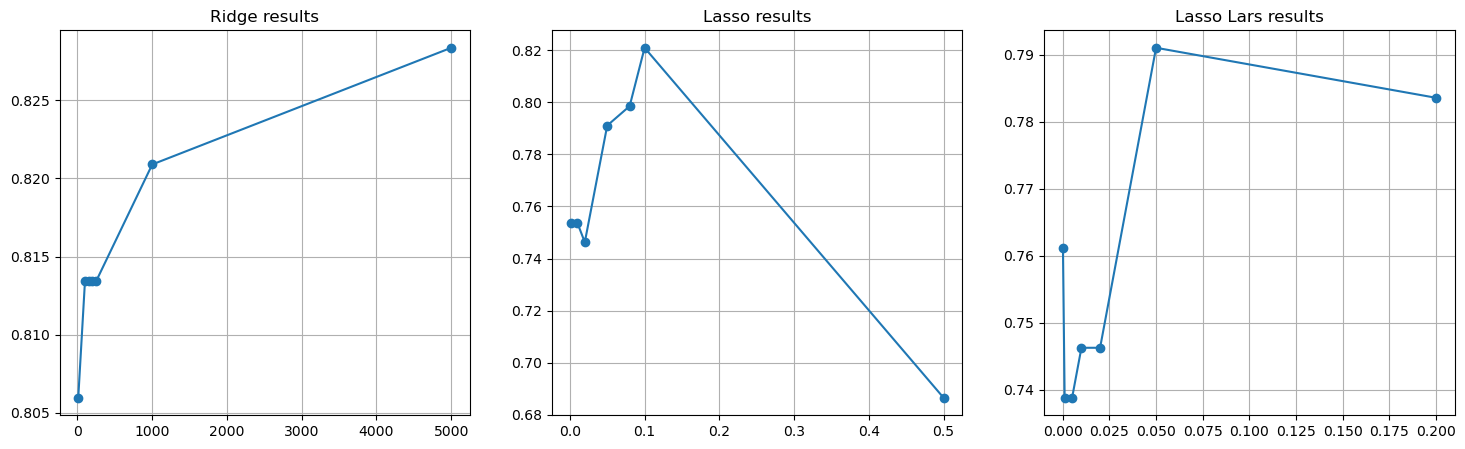

In [16]:
#Hyperparameter tuning
alphas_r = [10.0, 100.0, 150.0, 200.0, 250.0, 1000.0, 5000.0]
alphas_l = [0.001, 0.01, 0.02, 0.05, 0.08, 0.1, 0.5]
alphas_ll = [0.0001, 0.001, 0.005, 0.01, 0.02, 0.05, 0.2]

def evaluate_model(model):
    model.fit(x_train, y_train)
    y_pred = (model.predict(x_test) >= 0.45).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

ridge_results = []
lasso_results = []
lassol_results = []

for alpha in alphas_r:
    ridge_model = Ridge(alpha=alpha)
    ridge_accuracy = evaluate_model(ridge_model)
    ridge_results.append(ridge_accuracy)

for alpha in alphas_l:
    lasso_model = Lasso(alpha=alpha, max_iter=1000)
    lasso_accuracy = evaluate_model(lasso_model)
    lasso_results.append(lasso_accuracy)

for alpha in alphas_ll:
    lassol_model = LassoLars(alpha=alpha, max_iter=1000)
    lassol_accuracy = evaluate_model(lassol_model)
    lassol_results.append(lassol_accuracy)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(alphas_r, ridge_results, marker='o')
plt.title('Ridge results')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(alphas_l, lasso_results, marker='o')
plt.title('Lasso results')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(alphas_ll, lassol_results, marker='o')
plt.title('Lasso Lars results')
plt.grid()

plt.show()


Logistic Regression:
Best Threshold: 0.35, Maximum Accuracy: 83.5821%


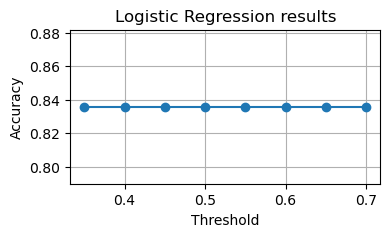


Linear Regression:
Best Threshold: 0.55, Maximum Accuracy: 83.5821%


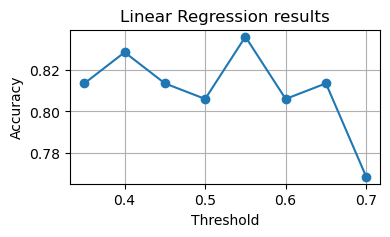


Ridge:
Best Threshold: 0.45, Maximum Accuracy: 83.5821%


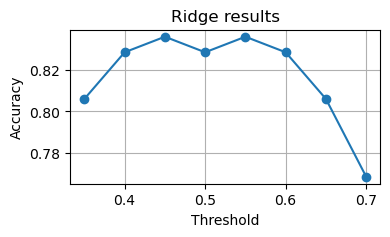


Lasso:
Best Threshold: 0.45, Maximum Accuracy: 79.1045%


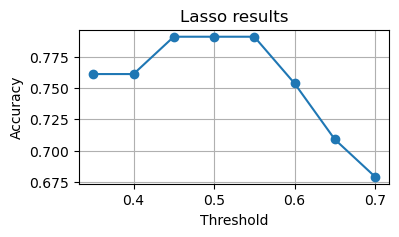


Lasso_Lars:
Best Threshold: 0.45, Maximum Accuracy: 82.0896%


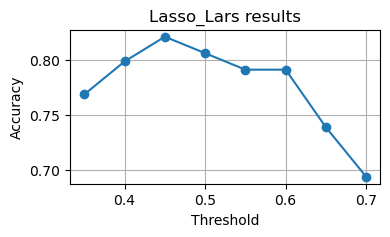


Bayesian_Ridge:
Best Threshold: 0.55, Maximum Accuracy: 83.5821%


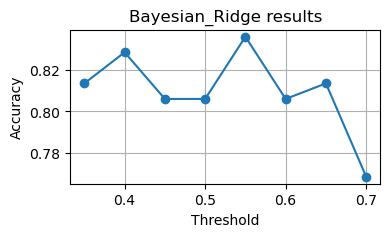

In [17]:
#Hyperparameter tuning
thresholds = [0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70]

def evaluate_model(model):
    model.fit(x_train, y_train)
    y_pred1 = model.predict(x_test)  
    results = []
    
    for t in thresholds:
        y_pred = (y_pred1 >= t).astype(int)  
        accuracy = accuracy_score(y_test, y_pred) 
        results.append((t, accuracy)) 
    return results

results = []
for name, model in models.items():
    model_results = evaluate_model(model)
    results.append((name, model_results))


for name, model_results in results:
    print(f"\n{name}:")
    threshold_list = []
    accuracy_list = []

    for threshold, accuracy in model_results:
        #print(f"Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}")
        threshold_list.append(threshold)
        accuracy_list.append(accuracy)

    max_accuracy = max(accuracy_list)
    best_threshold = threshold_list[accuracy_list.index(max_accuracy)]
    print(f"Best Threshold: {best_threshold:.2f}, Maximum Accuracy: {max_accuracy*100:.4f}%")
    
    plt.figure(figsize=(4, 2))
    plt.plot(threshold_list, accuracy_list, marker='o')
    plt.title(f'{name} results')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

In [61]:
#Voting Classifier
m1 = LogisticRegression(class_weight='balanced')
m2 = RidgeClassifier()
m3 = LogisticRegression(penalty='l2', solver='saga')

voting_clf = VotingClassifier(
    estimators=[
        ('lor', m1),
        ('rc', m2),
        ('lor2', m3)
    ],
    voting='hard'  
)

voting_clf.fit(x_train, y_train)

y_pred = voting_clf.predict(x_test)

print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

Voting Classifier Accuracy: 83.5820895522388 %


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [62]:
#Stacking classifier
base_learners = [
    ('lr', LinearRegression()),        
    ('ridge', Ridge()),                
    ('lor', LogisticRegression(class_weight='balanced')),     
]

meta_learner = LogisticRegression()

stacked_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner, 
    passthrough=False 
)

stacked_clf.fit(x_train, y_train)
y_pred = stacked_clf.predict(x_test)

print("Stacked Classifier Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")


Stacked Classifier Accuracy: 84.32835820895522 %


## 4. Best model vs Random guessing

In [ ]:
lor = LogisticRegression(C=0.1, solver='lbfgs', penalty='l2')

#Shuffling the test values 
y_randomized = shuffle(y_train)

model = lor.fit(x_train, y_randomized)
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred)*100, "%")

#Shuffling will only give us an accuracy of anywhere around 50%, since there are only 2 unique values in the data, and when we shuffle it,
#we remove meaning from the training data, where the 1 and 0 doesn't point to the tumor grade “II-” vs. “III+” anymore. 

### Building models with the actual train and test set now, choosing the best ones based on the observations above

## 5. Most important genes for model decision

In [43]:
#Finding the most important genes
model = lr.fit(train_X, train_y)

imp_df = pd.DataFrame({
    'Feature': train_X.columns, 
    'Coefficient': abs(model.coef_)
})

imp_df = imp_df.sort_values(by='Coefficient', ascending=False)
imp_df.head(10)

,Feature,Coefficient
1115,ENSG00000071677,0.003040
838,ENSG00000064218,0.002988
11497,ENSG00000168148,0.002847
14250,ENSG00000184502,0.002769
16161,ENSG00000204928,0.002647
6443,ENSG00000133636,0.002579
1865,ENSG00000091583,0.002571
10681,ENSG00000164532,0.002548
17321,ENSG00000244623,0.002494
13265,ENSG00000177947,0.002456


#### Bonus Question:
#### Finding the top 10 most important genes from Uniprot,
#### The model seems to have captured several genes involved in epigenetic regulation, hormonal pathways, and oxidative stress, all of which are well-documented in cancer biology. However, some genes, like olfactory receptors, may not be traditionally associated with cancer but represent emerging research areas.

### Top Genes:
#### PRLH (Prolactin-releasing peptide, ENSG00000071677)
#### DMRT3 (Doublesex and mab-3-related transcription factor 3, ENSG00000064218)
#### HIST3H3 (Histone H3.1t, ENSG00000168148)
#### GAST (Gastrin, ENSG00000184502)
#### GRXCR2 (Glutaredoxin domain-containing cysteine-rich protein 2, ENSG00000204928)
#### NTS (Neurotensin/neuromedin N, ENSG00000133636)
#### APOH (Apolipoprotein H, ENSG00000091583)
#### TBX20 (T-box transcription factor TBX20, ENSG00000164532)
#### OR2AE1 (Olfactory receptor 2AE1, ENSG00000244623)
#### CIMAP1A (Ciliary microtubule associated protein 1A, ENSG00000177947)


In [44]:
#Building a Logistic regression model which is trained on the top genes
top_features = imp_df['Feature'].head(8000)
train_X_top = train_X[top_features]
test_X_top = train_X[top_features]

model = lor.fit(train_X_top, train_y)
pred_y_lor_topgenes = model.predict(test_X_top)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(lor, train_X, train_y, cv=skf, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.5f}")

Cross-validation Accuracy: 0.82653


In [45]:
#Stacking classifier
base_learners = [
    ('lr', LinearRegression()),        
    ('ridge', Ridge()),                    
]

meta_learner = LogisticRegression()

stacked_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner, 
    passthrough=False 
)

stacked_clf.fit(train_X, train_y)
pred_y_sc = stacked_clf.predict(test_X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(stacked_clf, train_X, train_y, cv=skf, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.5f}")

Cross-validation Accuracy: 0.82199


In [7]:
#Hyperparameter tuning with Logistic Regression

lor = LogisticRegression(C=100, solver='lbfgs', max_iter=1000)
model = lor.fit(train_X, train_y)
pred_y_lor = model.predict(test_X)

In [70]:
lor = LogisticRegression(C=0.1, penalty='elasticnet', solver='saga', l1_ratio=0.35, max_iter=10000)
model = lor.fit(train_X, train_y)
pred_y_lor = model.predict(test_X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(lor, train_X, train_y, cv=skf, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.5f}")

Cross-validation Accuracy: 0.80631


In [82]:
lor = LogisticRegression(C=1, solver='liblinear', penalty='l2', max_iter=1000)
model = lor.fit(train_X, train_y)
pred_y_lor = model.predict(test_X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(lor, train_X, train_y, cv=skf, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.5f}")

Cross-validation Accuracy: 0.82880


In [105]:
lor = LogisticRegression(C=0.1, solver='liblinear', penalty='l2', max_iter=1000)
model = lor.fit(train_X, train_y)
pred_y_lor = model.predict(test_X)

skf = StratifiedKFold(n_splits=5, shuffle=True)
cross_val_scores = cross_val_score(lor, train_X, train_y, cv=skf, scoring='accuracy')
print(f"Cross-validation Accuracy: {cross_val_scores.mean():.5f}")

Cross-validation Accuracy: 0.84242


In [21]:
#Ridge
model = r.fit(train_X, train_y)
pred_y_r = model.predict(test_X)

In [22]:
#Logistic Regression
model = lor.fit(train_X, train_y)
pred_y_lor = model.predict(test_X)

In [23]:
#Linear Regression
model = lr.fit(train_X, train_y)
pred_y_lr = (model.predict(test_X) >= 0.45).astype(int)

In [24]:
#Ridge Classifier
model = rc.fit(train_X, train_y)
pred_y_rc = model.predict(test_X)

In [106]:
pd.DataFrame({
    'ID': ids, 
    'xml_neoplasm_histologic_grade': pred_y_lor #change here
}).to_csv('test_y_lorhyp7.csv', index=False) #change here

## 6. Visualizing the data

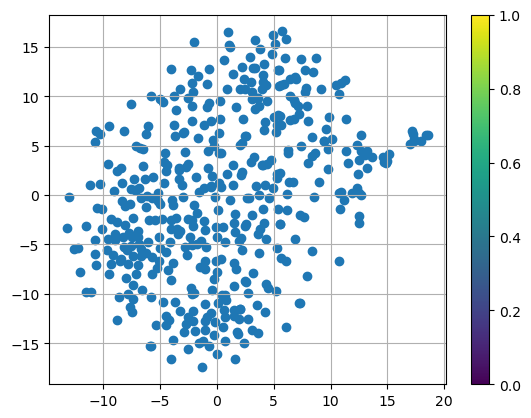

In [13]:
df = pd.DataFrame(train_X)

tsne = TSNE(n_components=2, random_state=42)
tsne_df = tsne.fit_transform(df)

plt.scatter(tsne_df[:, 0], tsne_df[:, 1])
plt.colorbar()
plt.grid()
plt.show()

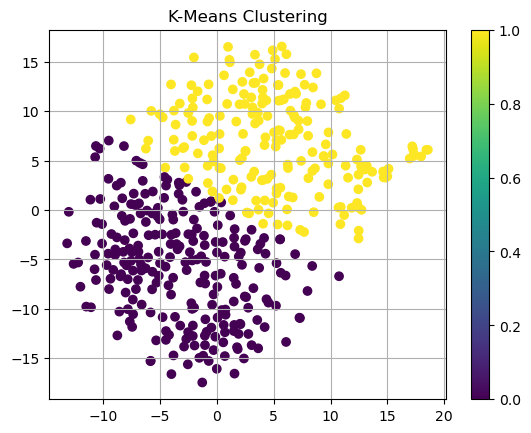

In [17]:
kmeans = KMeans(n_clusters=2, random_state=42)  
labels = kmeans.fit_predict(tsne_df)

plt.scatter(tsne_df[:, 0], tsne_df[:, 1], c=kmeans.labels_)
plt.colorbar()
plt.title("K-Means Clustering")
plt.grid()

### We can see that there are two clear clusters with minimal overlap. This overlap may indicate potential ambiguity and might affect the model's performance. 

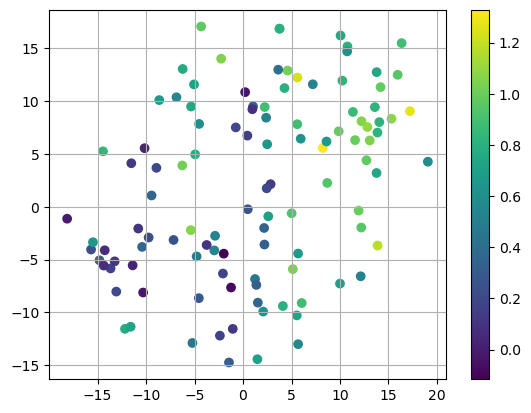

In [24]:
#Plotting the results of the linear regression model with t-SNE 

df_x = np.vstack([train_X, test_X])

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_x)

tsne_train = tsne_results[:len(train_X)] 
tsne_test = tsne_results[len(train_X):] 

model = lr.fit(train_X, train_y)

y_pred = model.predict(test_X)

plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=y_pred)
plt.colorbar()
plt.grid()
plt.show()